# <font color=darkblue> SmartTweet Combiné</font>

#### <font color=black> Importations de base</font>

In [3]:
import csv
import json
import tweepy
import keras
import numpy as np
from tweepy import OAuthHandler
import tensorflow as tf
import tensorflow.keras as K

#pour executer sur le GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

## <font color=darkred> Late Fusion</font>

#### <font color=black> Chargement des fonctions pour le texte</font>

In [47]:
import warnings
warnings.filterwarnings('ignore')

from random import randint
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras import activations
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from keras.datasets import cifar100

from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate, Dense, Embedding, Conv1D, Input, BatchNormalization, GlobalAveragePooling1D, Dropout, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import Constant


from keras.datasets import mnist, boston_housing
from sklearn.preprocessing import MinMaxScaler


In [3]:
EMBEDDING_DIM = 100

file = "glove.twitter.27B.100d.txt"

def get_embeddings_index(gloveFile):
    print('Indexing word vectors.')

    embeddings_index = {}
    with open(gloveFile , encoding='utf-8') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs

    print('Found {} word vectors.'.format(len(embeddings_index)))
    return embeddings_index


def get_embedding_matrix(num_words, max_num_words, word_index, gloveFile):
    embeddings_index = get_embeddings_index(gloveFile)

    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i >= max_num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

def get_pre_trained_embedding_layer(num_words, embedding_matrix, max_sequence_length):
    return Embedding(num_words, EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix),
                     input_length=max_sequence_length, trainable=False, name='embedded_sequence')

In [4]:
def get_texts_labels():
    texts=[]
    labels=[]
    with open('tweet2.csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            texts.append(row['texte '])
            labels.append(row['classe '])
    return texts, labels

In [5]:
def vector_label(a):
    ListLabel=['Fashion', 'Health', 'Tech', 'Sport', 'Cooking', 'Music', 'Videogames', 'Politic', 'Science', 'Cinema']
    c=[0]*10
    for i in range(0,10):
        if(a==ListLabel[i]):
            c[i]=1
    return c

In [6]:
MAX_SEQUENCE_LENGTH = 140
MAX_NUM_WORDS = 20000

# first, prepare text samples and their labels

texts, labels = get_texts_labels()


# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')


# split the data into a training set and a validation set
ListLabel=['Fashion', 'Health', 'Tech', 'Sport', 'Cooking', 'Music', 'Videogames', 'Politic', 'Science', 'Cinema']
x_train = []
y_train =[]
x_val = []
y_val =[]
d_i=0
for label in ListLabel:
    data_label=[]
    vect=vector_label(label)
    label_vect=[]
    while (d_i<len(data) and labels[d_i]==label):
        data_label.append(data[d_i])
        label_vect.append(vect)
        d_i+=1
    np.random.shuffle(data_label)
    indice_separation=int(0.8*len(data_label))
    x_train+= data_label[0: indice_separation]
    y_train+= label_vect[0: indice_separation]
    x_val += data_label[indice_separation : len(data_label)]
    y_val += label_vect[indice_separation : len(data_label)]

x_train=np.array(x_train)
y_train=np.array(y_train)
x_val=np.array(x_val)
y_val=np.array(y_val)

print(x_val.shape)

num_words = MAX_NUM_WORDS
embedding_matrix = get_embedding_matrix(num_words, MAX_NUM_WORDS, word_index, file)

# load pre-trained word embeddings into an Embedding layer
embedding_layer = get_pre_trained_embedding_layer(num_words, embedding_matrix, MAX_SEQUENCE_LENGTH)


(3214, 140)
Indexing word vectors.
Found 1193514 word vectors.


#### <font color=black> Chargement des fonctions pour l'image</font>

In [7]:
from PIL import Image
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Dropout, Dense, GlobalAveragePooling3D, Average
from tensorflow.keras.models import Model

In [99]:
def Label(jpg):
    ListLabel=['Fashion', 'Health', 'Tech', 'Sport', 'Cooking', 'Music', 'Videogames', 'Politic', 'Science', 'Cinema']
    y=[0]*10
    for i in range(0,10):
        if(jpg.find(ListLabel[i])!=-1):
            y[i]=1
    return y

#### <font color=black> Création du modèle late fusion</font>

In [95]:
def get_model_late(embedding_layer, max_sequence_length, nb_labels):
    sequence_input = Input(shape=(max_sequence_length), dtype='int32', name='sequence')
    embedded_sequence = embedding_layer(sequence_input)
    
    x_t = Conv1D(512, 5, activation='relu', padding='same')(embedded_sequence)
    x_t = Dropout(0.5)(x_t)
    x_t = Conv1D(512, 5, activation='relu', padding='same')(x_t)
    x_t = Dropout(0.5)(x_t)
    x_t = Conv1D(512, 5, activation='relu', padding='same')(x_t)
    x_t = Dropout(0.5)(x_t)
    x_t = Conv1D(512, 5, activation='relu', padding='same')(x_t)
    x_t = Dropout(0.5)(x_t)
    x_t = Conv1D(512, 5, activation='relu', padding='same')(x_t)
    x_t = Dropout(0.5)(x_t)
    x_t = Conv1D(512, 5, activation='relu', padding='same')(x_t)
    x_t = GlobalAveragePooling1D(data_format='channels_last')(x_t)
    topic_pred_t = Dense(units = (10), activation = 'softmax', name='topic_texte' )(x_t)
    
    image_input = tf.keras.Input(shape=(224, 224, 3))
    image_trunk = tf.keras.applications.VGG16(input_tensor=image_input, input_shape =(224, 224, 3),
        pooling     =None,
        include_top =False,
        weights     ='imagenet',
        layers      =K.layers
    )
 
#--- freeze ---#
    image_trunk.trainable = False
    
    x_image = image_trunk.output
    x_image = GlobalAveragePooling2D(data_format='channels_last')(x_image)
    topic_pred_image = Dense(units = 10, activation = 'softmax', name='topic_image' )(x_image)

    
    topic_pred1 = Average()([topic_pred_t, topic_pred_image])
    model = Model(inputs=[sequence_input,image_input], outputs=topic_pred1, name='fully_conv_batchnorm')
    return model

def get_compiled_model_late(embedding_layer, max_sequence_length, nb_labels):
    model = get_model_late(embedding_layer, max_sequence_length, nb_labels)

    model.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=['acc'])

    return model

model_late =get_compiled_model_late(embedding_layer, MAX_SEQUENCE_LENGTH, len(labels))
model_late.summary()

Model: "fully_conv_batchnorm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_27[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________

#### <font color=black> Ecriture du générateur de données d'entrainement et de validation</font>

In [17]:
def vectorize_text_batch(text):
    sequences = tokenizer.texts_to_sequences(text)
    mi=len(sequences[0])
    for i in range(mi, MAX_SEQUENCE_LENGTH):
        sequences[0].append(0)
    return sequences

In [115]:
def train_gen():
    dirs = os.listdir( "Images/" )
    i=0
    with open('tweet2_N.csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row["url de l_image "]:
                if(i%5!=0):
                    texts = vectorize_text_batch([row['texte_N']])[0]
                    classe= row['classe ']
                    for file in dirs:
                        if(file.find(classe + str(i) + '.jpg')!=-1):
                            image = np.array(Image.open("Images/" + file).resize((224, 224), Image.BILINEAR).convert('RGB')) / 255.
                    target = vector_label(classe)
                    yield ((texts, image), target)
                i+=1



ds_train_late = tf.data.Dataset.from_generator(
    train_gen,
    output_types=((tf.int32, tf.float32), tf.float32),
).shuffle(
    200
).padded_batch(
    32,
    padded_shapes=(([140], [224, 224, 3]), [10])
).prefetch(10)



def val_gen():
    dirs = os.listdir( "Images/" )
    i=0
    with open('tweet2_N.csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row["url de l_image "]:
                if(i%5==0):
                    texts = vectorize_text_batch([row['texte_N']])[0]
                    classe= row['classe ']
                    for file in dirs:
                        if(file.find(classe + str(i) + '.jpg')!=-1):
                            image = np.array(Image.open("Images/" + file).resize((224, 224), Image.BILINEAR).convert('RGB')) / 255.
                    target = vector_label(classe)
                    yield ((texts, image), target)
                i+=1

ds_val_late = tf.data.Dataset.from_generator(
    val_gen,
    output_types=((tf.int32, tf.float32), tf.float32),
).shuffle(
    200
).padded_batch(
    32,
    padded_shapes=(([140], [224, 224, 3]), [10])
).prefetch(10)

In [96]:
next(iter(ds_train_late))[0][1].shape

TensorShape([32, 224, 224, 3])

In [116]:
next(iter(ds_val_late))

((<tf.Tensor: id=404448, shape=(32, 140), dtype=int32, numpy=
  array([[ 1183, 18541,    12, ...,     0,     0,     0],
         [18555,    24,     4, ...,     0,     0,     0],
         [  318,  2264,    15, ...,     0,     0,     0],
         ...,
         [  337,     4,   239, ...,     0,     0,     0],
         [   14,   457,  1617, ...,     0,     0,     0],
         [    4,  2016,   510, ...,     0,     0,     0]], dtype=int32)>,
  <tf.Tensor: id=404449, shape=(32, 224, 224, 3), dtype=float32, numpy=
  array([[[[0.99215686, 0.99215686, 1.        ],
           [0.99215686, 0.9882353 , 1.        ],
           [0.99215686, 0.99215686, 1.        ],
           ...,
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ],
           [1.        , 1.        , 1.        ]],
  
          [[0.99607843, 0.99607843, 1.        ],
           [0.99607843, 0.99607843, 1.        ],
           [0.99607843, 0.99607843, 1.        ],
           ...,
           

#### <font color=black> Entrainement du modèle</font>

In [117]:
batch_size = 32
epochs = 150
#opt=0.0001

earlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=20, restore_best_weights=True)
history = model_late.fit(ds_train_late, batch_size=None, epochs=epochs, callbacks=[earlyStopping], verbose=1, validation_data=ds_val_late)
score = model_late.evaluate(ds_val_late, verbose=0)

Epoch 1/150
223/223 [==============================] - 81s 363ms/step - loss: 2.5991 - acc: 0.1663 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/150
223/223 [==============================] - 78s 351ms/step - loss: 2.1655 - acc: 0.1663 - val_loss: 2.6887 - val_acc: 0.1665
Epoch 3/150
223/223 [==============================] - 78s 351ms/step - loss: 2.1499 - acc: 0.1663 - val_loss: 2.6848 - val_acc: 0.1665
Epoch 4/150
223/223 [==============================] - 78s 351ms/step - loss: 2.1536 - acc: 0.1663 - val_loss: 2.6765 - val_acc: 0.1665
Epoch 5/150
223/223 [==============================] - 81s 363ms/step - loss: 2.1401 - acc: 0.1663 - val_loss: 2.6791 - val_acc: 0.1665
Epoch 6/150
223/223 [==============================] - 78s 351ms/step - loss: 2.1468 - acc: 0.1663 - val_loss: 2.6693 - val_acc: 0.1665
Epoch 7/150
223/223 [==============================] - 82s 367ms/step - loss: 2.1251 - acc: 0.1663 - val_loss: 2.6697 - val_acc: 0.1665
Epoch 8/150
223/223 [===================

#### <font color=black> Courbe de perte</font>

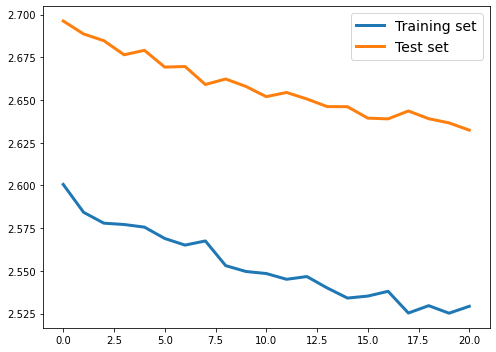

In [118]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['loss'], lw=3, label='Training set')
plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Test set')
plt.legend(fontsize=14)
plt.tight_layout()

#### <font color=black> Courbe de précision</font>

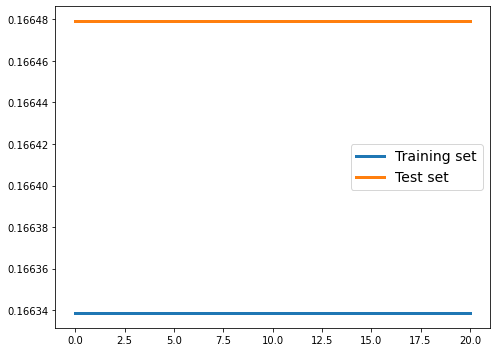

In [119]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['acc'], lw=3, label='Training set')
plt.plot(history.epoch, history.history['val_acc'], lw=3, label='Test set')
plt.legend(fontsize=14)
plt.tight_layout()

## <font color=darkred> Early Fusion</font>

#### <font color=black> Création du modèle early fusion</font>

In [74]:
def get_model_early(embedding_layer, max_sequence_length, nb_labels):
    
    sequence_input = Input(shape=(max_sequence_length), dtype='int32', name='sequence')
    embedded_sequence = embedding_layer(sequence_input)
    
    x_t = Conv1D(512, 5, activation='relu', padding='same')(embedded_sequence)
    x_t = Dropout(0.5)(x_t)
    x_t = Conv1D(512, 5, activation='relu', padding='same')(x_t)
    x_t = Dropout(0.5)(x_t)
    x_t = Conv1D(512, 5, activation='relu', padding='same')(x_t)
    x_t = Dropout(0.5)(x_t)
    x_t = Conv1D(512, 5, activation='relu', padding='same')(x_t)
    x_t = Dropout(0.5)(x_t)
    x_t = Conv1D(512, 5, activation='relu', padding='same')(x_t)
    x_t = Dropout(0.5)(x_t)
    x_t = Conv1D(512, 5, activation='relu', padding='same')(x_t)
    x_t = GlobalAveragePooling1D(data_format='channels_last')(x_t)
    
    
    image_input = tf.keras.Input(shape=(224, 224, 3))
    image_trunk = tf.keras.applications.VGG16(input_tensor=image_input, input_shape =(224, 224, 3),
        pooling     =None,
        include_top =False,
        weights     ='imagenet',
        layers      =K.layers
    )
 
#--- freeze ---#
    image_trunk.trainable = False
    
    x_image = image_trunk.output
    x_image = GlobalAveragePooling2D(data_format='channels_last')(x_image)
    
    
    x = concatenate([x_t, x_image], axis=-1)
    topic_pred = Dense(units = 10, activation = 'softmax', name='topic' )(x)
    model = Model(inputs=[sequence_input,image_input], outputs=topic_pred, name='fully_conv_batchnorm')
    return model

def get_compiled_model_early(embedding_layer, max_sequence_length, nb_labels):
    model = get_model_early(embedding_layer, max_sequence_length, nb_labels)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return model

model_early =get_compiled_model_early(embedding_layer, MAX_SEQUENCE_LENGTH, len(labels))
model_early.summary()


Model: "fully_conv_batchnorm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_23[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________

#### <font color=black> Création du générateur</font>

In [25]:
def vectorize_text_batch(text):
    sequences = tokenizer.texts_to_sequences(text)
    mi=len(sequences[0])
    for i in range(mi, MAX_SEQUENCE_LENGTH):
        sequences[0].append(0)
    return sequences

In [120]:
def train_gen():
    dirs = os.listdir( "Images/" )
    i=0
    with open('tweet2_N.csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row["url de l_image "]:
                if(i%5!=0):
                    texts = vectorize_text_batch([row['texte_N']])[0]
                    classe= row['classe ']
                    for file in dirs:
                        if(file.find(classe + str(i) + '.jpg')!=-1):
                            image = np.array(Image.open("Images/" + file).resize((224, 224), Image.BILINEAR).convert('RGB')) / 255.
                    target = vector_label(classe)
                    yield ((texts, image), target)
                i+=1


ds_train_late = tf.data.Dataset.from_generator(
    train_gen,
    output_types=((tf.int32, tf.float32), tf.float32),
).shuffle(
    200
).padded_batch(
    32,
    padded_shapes=(([140], [224, 224, 3]), [10])
).prefetch(10)

print(ds_train_late)

def val_gen():
    dirs = os.listdir( "Images/" )
    i=0
    with open('tweet2_N.csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row["url de l_image "]:
                if(i%5==0):
                    texts = vectorize_text_batch([row['texte_N']])[0]
                    classe= row['classe ']
                    for file in dirs:
                        if(file.find(classe + str(i) + '.jpg')!=-1):
                            image = np.array(Image.open("Images/" + file).resize((224, 224), Image.BILINEAR).convert('RGB')) / 255.
                    target = vector_label(classe)
                    yield ((texts, image), target)
                i+=1


ds_val_late = tf.data.Dataset.from_generator(
    val_gen,
    output_types=((tf.int32, tf.float32), tf.float32),
).shuffle(
    200
).padded_batch(
    32,
    padded_shapes=(([140], [224, 224, 3]), [10])
).prefetch(10)

<DatasetV1Adapter shapes: (((None, 140), (None, 224, 224, 3)), (None, 10)), types: ((tf.int32, tf.float32), tf.float32)>


#### <font color=black> Entrainement du modèle</font>

In [121]:
batch_size = 128
epochs = 150

earlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=30, restore_best_weights=True)
history = model_early.fit(ds_train_late, batch_size=None, epochs=epochs, callbacks=[earlyStopping], verbose=1, validation_data=ds_val_late)
score = model_early.evaluate(ds_val_late, verbose=0)

Epoch 1/150
223/223 [==============================] - 84s 377ms/step - loss: 9.9083 - acc: 0.1332 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/150
223/223 [==============================] - 82s 369ms/step - loss: 4.9712 - acc: 0.1748 - val_loss: 3.7861 - val_acc: 0.1468
Epoch 3/150
223/223 [==============================] - 82s 368ms/step - loss: 4.0388 - acc: 0.1938 - val_loss: 3.4378 - val_acc: 0.1631
Epoch 4/150
223/223 [==============================] - 82s 369ms/step - loss: 3.4920 - acc: 0.2058 - val_loss: 3.1584 - val_acc: 0.1766
Epoch 5/150
223/223 [==============================] - 82s 367ms/step - loss: 3.1206 - acc: 0.2188 - val_loss: 2.9715 - val_acc: 0.1856
Epoch 6/150
223/223 [==============================] - 82s 370ms/step - loss: 2.9107 - acc: 0.2553 - val_loss: 2.8512 - val_acc: 0.1929
Epoch 7/150
223/223 [==============================] - 82s 369ms/step - loss: 2.7389 - acc: 0.2724 - val_loss: 2.7669 - val_acc: 0.1969
Epoch 8/150
223/223 [===================

#### <font color=black> Courbe de perte</font>

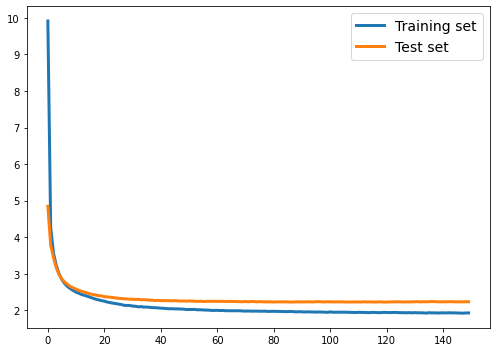

In [122]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['loss'], lw=3, label='Training set')
plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Test set')
plt.legend(fontsize=14)
plt.tight_layout()

#### <font color=black> Courbe de précision</font>

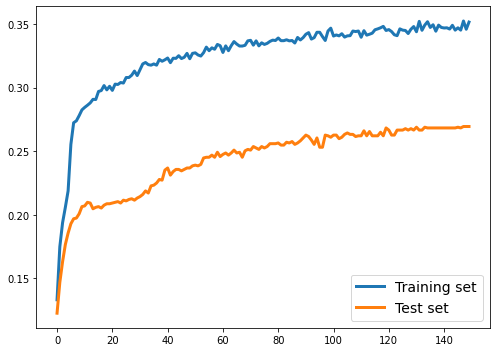

In [123]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['acc'], lw=3, label='Training set')
plt.plot(history.epoch, history.history['val_acc'], lw=3, label='Test set')
plt.legend(fontsize=14)
plt.tight_layout()